In [39]:
import tensorflow as tf
import pandas as pd
import numpy as np
import sklearn 
from keras.layers import Dense
from keras.models import Sequential
import os
import matplotlib.pyplot as plt
import math

df = pd.read_csv('/home/saichaitanya/Chaitanya/CSV files/1000 points per trajectory/May10rd1percent_RLV_data 1000 points.csv',header = None,names = ['h','v','s','omega','gamma','m','theta','Thrust','beta','time'])
input = output =df.values
X = input[:,0:7]
y = output[:,7:9]
# Individual Data
from sklearn import preprocessing
X_norm = preprocessing.minmax_scale(X)
y_norm = preprocessing.minmax_scale(y)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_norm, y_norm, test_size=0.1, random_state=42)
X_val = X_train[-10000:]
y_val = y_train[-10000:]
X_train = X_train[:-10000]
y_train = y_train[:-10000]

R0 = 6378*1000;
g0=9.81
Cd = 0.5
S_ref =10.75
Isp =300;
I_z = 3346393
l_com = 9.778
t_ref = 32
h0=5000;
v0=325;
s0=850;
## The inputs and outputs which varied have values in decimals 
## rest all have been rounded off to 5-6 digits
omega0= 0.342
theta0= round(-75*math.pi/180,4)
gamma0= round(-75*math.pi/180,4) #
m0= round(26229.667,0) # our values of mass are rounded of when taking data
r0 = h0+6378000

## Here we are finding the trajectory which relates to the given input conditions

# First we find the index of the row where we have the given initial conditions, we validate if we had 
# taken the correct trajectory for that we need to check the ending values of s such that s = s0.
idx = df.loc[(df['h'] == h0) & (df['v'] == v0)]
idx = np.array(idx.index.astype(int))
def trajectory_finding(idx,df,s0):
    # we have 3003 points for getting full trajectory starting from index 0-3002
    for i in range(idx.shape[0]):
        df2= df[idx[0]+3003*i:idx[0]+3003*(i+1)]
        if (df2.s.values[3002]==s0):
            break
        else:
            continue
    return np.array([df2.index[0],df2.index[3002]])

idx_i,idx_f = trajectory_finding(idx,df,s0)

## Normalizing the inputs
def norm(a,b):
    return (a - min(b))/(max(b) - min(b))
def norm_inputs(a,b):
    return (a-min(b))/(max(b)-min(b))

h = X[:,0];
v = X[:,1];
s = X[:,2];
omega = X[:,3]
gamma= X[:,4]
m = X[:,5]
theta = X[:,6]
T = y[:,0]
b = y[:,1]
r = 6378000+h

h_norm = norm_inputs(h,h)
v_norm= norm_inputs(v,v)
s_norm= norm_inputs(s,s)
omega_norm= norm_inputs(omega,omega)
gamma_norm= norm_inputs(gamma,gamma)
m_norm= norm_inputs(m,m)
theta_norm= norm_inputs(theta,theta)
r_norm = norm_inputs(r,r)
T_norm = norm_inputs(T,T)
b_norm = norm_inputs(b,b)

data_norm = np.array([h_norm,v_norm,s_norm,omega_norm,gamma_norm,m_norm,theta_norm,T_norm,b_norm]).T
df_norm = pd.DataFrame(data_norm,columns=['h','v','s','omega','gamma','m','theta','Thrust','beta'])
# Trajectory for the given initial condition:
data_traj = df_norm.values[idx_i:idx_f+1][:,0:9]
ip_traj = data_traj[:,0:7]
op_traj = data_traj[:,7:9]

In [41]:
def AntiNorm(Norm_value,actual):
  return (max(actual)-min(actual))*Norm_value+min(actual)

# local variables within the DNN function
ω2 = [];
θ2 = [];
v2 = [];
γ2 = [];
r2 = [];
s2 = [];
h2 = [];

# global variables for appending
ω_dnn = [];
θ_dnn = [];
v_dnn = [];
γ_dnn = [];
r_dnn = [];
s_dnn = [];
h_dnn = [];
m_dnn = [];
b_dnn = [];
T_dnn = [];


# Giving the initial trajectory conditions 



In [42]:
h1 = h_norm[idx_i]
s1 = s_norm[idx_i]
v1 = v_norm[idx_i]
omega1 = omega_norm[idx_i]
m1 = m_norm[idx_i]
theta1 = theta_norm[idx_i]
gamma1 = gamma_norm[idx_i]
r1 = r_norm[idx_i] # this is < 1 since 1 is 5025.2

n= 3003

# Loading model


In [14]:
def create_model2(n):
    model = Sequential()
    model.add(Dense(n,input_shape=(7,),kernel_initializer='uniform'))
    model.add(Dense(n,kernel_initializer='uniform',activation = 'relu'))
    model.add(Dense(n,kernel_initializer='uniform',activation = 'relu')) # since tanh has more nonlinearity we add it here, it also gives -ve values so , some layers which are not necessary will lead to 0 in next layer
    model.add(Dense(n,kernel_initializer='uniform',activation = 'relu'))
    model.add(Dense(n,kernel_initializer='uniform',activation = 'relu'))
    model.add(Dense(2,kernel_initializer='uniform',activation = 'sigmoid'))
    return model

i = 7;
model = create_model2(2**i)
path_Of_model =f"/home/saichaitanya/Chaitanya/GOOGLE COLAB  DOCS/1new percent variation/1000 points 7 states and 2 op with val_set having 128 neurons and batchsize 256/cp.ckpt"
model.load_weights(path_Of_model)

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.mean_squared_error
model.compile(optimizer=opt,loss=loss,metrics='accuracy')
# loss,accuracy = model.evaluate(X_norm,y_norm)

h_dnn = np.append(h_dnn,h1)
r_dnn = np.append(r_dnn,r1)
s_dnn = np.append(s_dnn,s1)
γ_dnn = np.append(γ_dnn,gamma1)
m_dnn = np.append(m_dnn,m1)
θ_dnn = np.append(θ_dnn,theta1)
ω_dnn = np.append(ω_dnn,omega1)
v_dnn = np.append(v_dnn,v1)


In [59]:
def Euler(number_of_steps,height,down_s_dis,velocity,ω,θ,γ,mass,radius,model):
    h1=height; r1=radius; s1=down_s_dis; gamma1=γ; theta1=θ; m1=mass; omega1= ω; v1=velocity
    
    h_step = 1/3003;
    
    h_dnn = np.append([],h1)
    r_dnn = np.append([],r1)
    s_dnn = np.append([],s1)
    γ_dnn = np.append([],gamma1)
    m_dnn = np.append([],m1)
    θ_dnn = np.append([],theta1)
    ω_dnn = np.append([],omega1)
    v_dnn = np.append([],v1)
    ip_i = np.array([h1,v1,s1,omega1,gamma1,m1,theta1]).reshape(1,7)  
    data_i = model.predict(ip_i)
    T1_i,b1_i = np.squeeze(data_i)
    b_dnn = np.append([],b1_i)
    T_dnn = np.append([],T1_i)
    for _ in range(n):
        ip = np.array([h1,v1,s1,omega1,gamma1,m1,theta1]).reshape(1,7)  
        data = model.predict(ip)
        T1,b1 = np.squeeze(data)
        # we should antinormalize the angles before substituting in Euler method
        b1 = AntiNorm(b1,b)
        omega1 = AntiNorm(omega1,omega)
        theta1 = AntiNorm(theta1,theta)
        gamma1 = AntiNorm(gamma1,gamma)
        ## code for Euler implementation
        # omega
        c2 = (t_ref*m0*g0*l_com/I_z)
        omega2 = omega1  - T1*np.sin(b1)*c2 * h_step
        # theta
        theta2 = theta1 + t_ref*omega1 * h_step
        # mass 
        m2 = m1 -(t_ref/Isp)*T1 * h_step
        # gamma
        gamma2 = gamma1 -(g0*t_ref/v0) *(((T1 * np.sin(b1 - gamma1 + theta1))/(m1*v1)) + (np.cos(gamma1)/(r1**2 * v1))) * h_step
        # velocity
        c1 = 0.5*1.225*Cd*(v0)**2 *S_ref / (m0*g0)
        D1 = c1 * v1**2
        v2 = v1 -(g0*t_ref/v0) *(((T1 * np.cos(b1 - gamma1 + theta1) + D1)/m1) + (np.sin(gamma1)/(r1**2))) * h_step
        # downrange
        c4 = (v0*t_ref/s0)
        s2 = s1 + c4 * v1 * np.cos(gamma1) * h_step
        # radius from COE
        c3 = (v0*t_ref/R0)
        r2 = r1 + c3 * v1 * np.sin(gamma1) * h_step
        # height 
        h2 = norm(AntiNorm(r2,r)-6378000,h)
#         print("before normalizing")
#         print(_,omega2,theta2,gamma2)
        

        ## We should normalize the outputs before sending into the NN model
        omega2 = norm(omega2,omega)
        theta2 = norm(theta2,theta)
        gamma2 = norm(gamma2,gamma)
#         print("after normalizing")
#         print(omega2,theta2,gamma2)


        ## stating the new values as inputs for the next iteration ALL THE VALUES HERE ARE NORMALIZED
        r1 = r2;
        s1 = s2;
        gamma1 = gamma2
        h1 = h2;
        m1 = m2;
        theta1 = theta2;
        omega1 = omega2;
        v1= v2;
        print(_,round(h1,5),round(v1,5),round(s1,5),round(omega1,5),round(gamma1,5),round(m1,5),round(theta1,5),round(T1,5),round(b1,5))
        ## Storing the data set of all values to get a trajectory from the given outputs
        h_dnn = np.append(h_dnn,h1)
        r_dnn = np.append(r_dnn,r1)
        s_dnn = np.append(s_dnn,s1)
        γ_dnn = np.append(γ_dnn,gamma1)
        m_dnn = np.append(m_dnn,m1)
        θ_dnn = np.append(θ_dnn,theta1)
        ω_dnn = np.append(ω_dnn,omega1)
        v_dnn = np.append(v_dnn,v1)
        
        ## storing the controls also in vector
        b_dnn = np.append(b_dnn,b1) # these dnns are initialized with 0 
        T_dnn = np.append(T_dnn,T1)# these dnns are initialized with 0 
        
    return h_dnn,r_dnn,s_dnn,γ_dnn,m_dnn,θ_dnn,ω_dnn,v_dnn,b_dnn,T_dnn
        

In [60]:
n = 10

In [61]:
h_dnn,r_dnn,s_dnn,γ_dnn,m_dnn,θ_dnn,ω_dnn,v_dnn,b_dnn,T_dnn= Euler(n,h1,s1,v1,omega1,theta1,gamma1,m1,r1,model)

0 0.99498 0.99474 0.00105 0.95777 0.54457 0.99999 0.62895 0.22955 0.04302
1 0.99498 0.99456 0.0021 0.95769 0.54443 0.99999 0.63075 0.19215 0.03731
2 0.99498 0.9944 0.00315 0.95764 0.54428 0.99998 0.63255 0.15792 0.03058
3 0.99498 0.99424 0.00419 0.95761 0.54414 0.99997 0.63435 0.12841 0.02352
4 0.99498 0.99409 0.00524 0.95759 0.544 0.99997 0.63614 0.10655 0.01653
5 0.99498 0.99394 0.00629 0.95758 0.54386 0.99997 0.63794 0.09141 0.01042
6 0.99498 0.9938 0.00733 0.95758 0.54371 0.99997 0.63974 0.07832 0.00488
7 0.99498 0.99367 0.00838 0.95758 0.54357 0.99996 0.64153 0.0675 6e-05
8 0.99498 0.99353 0.00942 0.95758 0.54343 0.99996 0.64333 0.05851 -0.0041
9 0.99498 0.9934 0.01047 0.95758 0.54329 0.99996 0.64513 0.04816 -0.00796


In [75]:
pred = model.predict(X_norm)

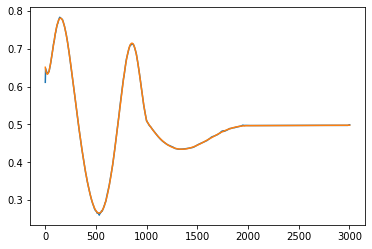

In [135]:
i=1
j = int(idx_i/3003)
no = 0
plt.plot(pred[:,i][0+3003*j:3003*(j+1)])
plt.plot(y_norm[:,i][0+3003*j:3003*(j+1)])
plt.legend(['pred','actual'])

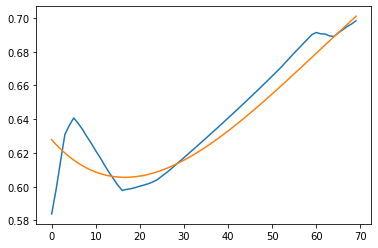

In [141]:
plt.plot(pred[:,i][0+no:70],label = 'pred')
plt.plot(y_norm[:,i][0+no:70])
plt.legend(['pred','actual'])


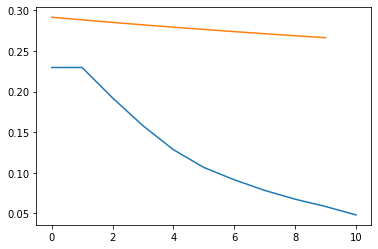

In [107]:
plt.plot(T_dnn)
plt.plot(T_norm[idx_i:idx_i+10])

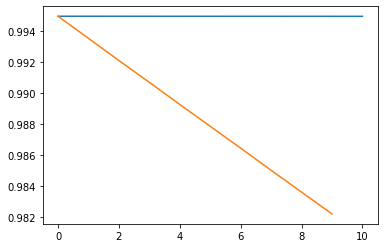

In [63]:
plt.plot(h_dnn)
plt.plot(h_norm[idx_i:idx_i+10])

In [64]:
df_norm[idx_i:idx_i+10]

,h,v,s,omega,gamma,m,theta,Thrust,beta
1093092,0.994985,0.994932,6.319090e-09,0.957870,0.544715,1.000000,0.627156,0.291385,0.651044
1093093,0.993553,0.993346,2.226162e-03,0.955451,0.544218,0.999143,0.631004,0.288167,0.649236
1093094,0.992120,0.991792,4.446765e-03,0.953071,0.543886,0.998287,0.634852,0.285027,0.647533
1093095,0.990707,0.990237,6.661582e-03,0.950731,0.543388,0.997430,0.638652,0.282041,0.645934
1093096,0.989274,0.988683,8.870614e-03,0.948403,0.542890,0.996788,0.642451,0.279158,0.644437
1093097,0.987861,0.987128,1.107386e-02,0.946115,0.542393,0.995931,0.646201,0.276378,0.643040
1093098,0.986448,0.985605,1.327132e-02,0.943852,0.541895,0.995075,0.649950,0.273701,0.641741
1093099,0.985016,0.984050,1.546277e-02,0.941616,0.541397,0.994433,0.653700,0.271101,0.640540
1093100,0.983603,0.982527,1.764843e-02,0.939392,0.540899,0.993576,0.657401,0.268630,0.639433
1093101,0.982190,0.981003,1.982714e-02,0.937194,0.540236,0.992719,0.661101,0.266210,0.638421


In [44]:
df[['omega','theta','gamma']][idx_i:idx_i+10]

,omega,theta,gamma
1093092,0.34200,-1.3090,-1.3090
1093093,0.34014,-1.3012,-1.3093
1093094,0.33831,-1.2934,-1.3095
1093095,0.33651,-1.2857,-1.3098
1093096,0.33472,-1.2780,-1.3101
1093097,0.33296,-1.2704,-1.3104
1093098,0.33122,-1.2628,-1.3107
1093099,0.32950,-1.2552,-1.3110
1093100,0.32779,-1.2477,-1.3113
1093101,0.32610,-1.2402,-1.3117


In [150]:
ip = np.array([h1,v1,s1,omega1,gamma1,m1,theta1]).reshape(1,7)  
h_step = 1/3003

In [156]:
data = model.predict(ip)
T1,b1 = np.squeeze(data)


In [158]:
T1

1.0

In [161]:
AntiNorm(0.651044,b)

0.05808817712

In [160]:
b1 = AntiNorm(b1,b)
b1

-0.11668643216575819

In [ ]:
# we should antinormalize the angles before substituting in Euler method
b1 = AntiNorm(b1,b)
omega1 = AntiNorm(omega1,omega)
theta1 = AntiNorm(theta1,theta)
gamma1 = AntiNorm(gamma1,gamma)
## code for Euler implementation
# omega
c2 = (t_ref*m0*g0*l_com/I_z)
omega2 = omega1  - T1*np.sin(b1)*c2 * h_step
print(omega1,omega2)
# theta
theta2 = theta1 + t_ref*omega1 * h_step
# mass 
m2 = m1 -(t_ref/Isp)*T1 * h_step
# gamma
gamma2 = gamma1 -(g0*t_ref/v0) *(((T1 * np.sin(b1 - gamma1 + theta1))/(m1*v1)) + (np.cos(gamma1)/(r1**2 * v1))) * h_step
# velocity
c1 = 0.5*1.225*Cd*(v0)**2 *S_ref / (m0*g0)
D1 = c1 * v1**2
v2 = v1 -(g0*t_ref/v0) *(((T1 * np.cos(b1 - gamma1 + theta1) + D1)/m1) + (np.sin(gamma1)/(r1**2))) * h_step
# downrange
c4 = (v0*t_ref/s0)
s2 = s1 + c4 * v1 * np.cos(gamma1) * h_step
# radius from COE
c3 = (v0*t_ref/R0)
r2 = r1 + c3 * v1 * np.sin(gamma1) * h_step
# height 
h2 = norm(AntiNorm(r2,r)-6378000,h)


In [ ]:

## We should normalize the outputs before sending into the NN model
omega2 = norm(omega2,omega)
theta2 = norm(theta2,theta)
gamma2 = norm(gamma2,gamma)
## stating the new values as inputs for the next iteration ALL THE VALUES HERE ARE NORMALIZED
r1 = r2;
s1 = s2;
gamma1 = gamma2
h1 = h2;
m1 = m2;
theta1 = theta2;
omega1 = omega2;
v1= v2;
## Storing the data set of all values to get a trajectory from the given outputs
h_dnn = np.append(h_dnn,h1)
r_dnn = np.append(r_dnn,r1)
s_dnn = np.append(s_dnn,s1)
γ_dnn = np.append(γ_dnn,gamma1)
m_dnn = np.append(m_dnn,m1)
θ_dnn = np.append(θ_dnn,theta1)
ω_dnn = np.append(ω_dnn,omega1)
v_dnn = np.append(v_dnn,v1)

## storing the controls also in vector
b_dnn = np.append(b_dnn,b1)
T_dnn = np.append(T_dnn,T1)